In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, Normal
from statsmodels.tsa.stattools import adfuller
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_predict
from pandas import datetime
from matplotlib import pyplot
import math
import statsmodels.tsa.api as smt
from scipy import stats
import scipy
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

C:\Users\srika\AppData\Local\Temp\ipykernel_32804\585549616.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [7]:
SP500 = yf.download("^GSPC", start = '2012-6-17', end = '2022-6-18')
BAC = yf.download("BAC", start = '2012-6-17', end = '2022-6-18')

SP500 = SP500.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
BAC = BAC.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)

data = pd.merge(BAC, SP500, on = 'Date', how = 'left').dropna()
data = data.rename(columns = {'Adj Close_x' : 'BAC Adj Close'})
data = data.rename(columns = {'Adj Close_y' : 'SnP500 Adj Close'})
data = data.reset_index()
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,BAC Adj Close,SnP500 Adj Close
0,2012-06-18,6.661011,1344.780029
1,2012-06-19,6.961441,1357.979980
2,2012-06-20,6.987193,1355.689941
3,2012-06-21,6.712514,1325.510010
4,2012-06-22,6.815519,1335.020020
...,...,...,...
2513,2022-06-13,32.020000,3749.629883
2514,2022-06-14,31.459999,3735.479980
2515,2022-06-15,32.049999,3789.989990
2516,2022-06-16,31.850000,3666.770020


In [8]:
data['SnP500_Log_Return'] = 100 * np.log(data['SnP500 Adj Close'] / data['SnP500 Adj Close'].shift(1))

data['BAC_Log_Return'] = 100 * np.log(data['BAC Adj Close'] / data['BAC Adj Close'].shift(1))
data = data.dropna()

In [9]:
data

,Date,BAC Adj Close,SnP500 Adj Close,SnP500_Log_Return,BAC_Log_Return
1,2012-06-19,6.961441,1357.979980,0.976783,4.411519
2,2012-06-20,6.987193,1355.689941,-0.168778,0.369242
3,2012-06-21,6.712514,1325.510010,-2.251321,-4.010538
4,2012-06-22,6.815519,1335.020020,0.714899,1.522873
5,2012-06-25,6.523671,1313.719971,-1.608350,-4.376506
...,...,...,...,...,...
2513,2022-06-13,32.020000,3749.629883,-3.953993,-3.528508
2514,2022-06-14,31.459999,3735.479980,-0.378082,-1.764385
2515,2022-06-15,32.049999,3789.989990,1.448706,1.858029
2516,2022-06-16,31.850000,3666.770020,-3.305221,-0.625977


In [10]:
#In Sample 
data_in_sample = data.loc[:1936]
#in_sample_BAC = data.loc[:1936]

#Evaluation
data_evaluation = data.loc[1937:]
data_evaluation.tail()

,Date,BAC Adj Close,SnP500 Adj Close,SnP500_Log_Return,BAC_Log_Return
2513,2022-06-13,32.020000,3749.629883,-3.953993,-3.528508
2514,2022-06-14,31.459999,3735.479980,-0.378082,-1.764385
2515,2022-06-15,32.049999,3789.989990,1.448706,1.858029
2516,2022-06-16,31.850000,3666.770020,-3.305221,-0.625977
2517,2022-06-17,31.920000,3674.840088,0.219845,0.219538


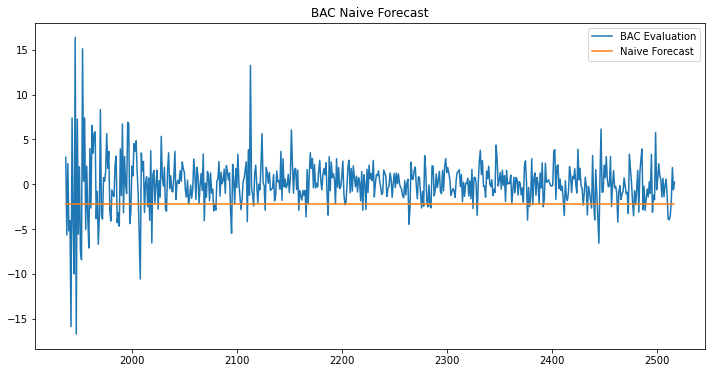

In [14]:
#Naive 
in_sample_array = np.array(data_in_sample['BAC_Log_Return'])
y_hat = data_evaluation.copy()
y_hat["Naive Forecast"] = in_sample_array[len(in_sample_array) - 1]
plt.figure(figsize = (12,6))
plt.plot(data_evaluation['BAC_Log_Return'], label = 'BAC Evaluation')
plt.plot(y_hat['Naive Forecast'], label = 'Naive Forecast')
plt.legend(loc = 'best')
plt.title("BAC Naive Forecast")
plt.show()

In [15]:
#Calculate the RMSFE and RMAFE values for Naive Model 

#RMSE
MSE = mean_squared_error(data_evaluation['BAC_Log_Return'], y_hat['Naive Forecast'])
RMSFE = math.sqrt(MSE)

#RMAE
MAE = mean_absolute_error(data_evaluation['BAC_Log_Return'], y_hat['Naive Forecast'])
RMAFE = math.sqrt(MAE)

print("Root Mean Square Forecast Error: " + str(RMSFE))
print("Root Mean Absolute Forecast Error: " + str(RMAFE))

Root Mean Square Forecast Error: 3.552010530714908
Root Mean Absolute Forecast Error: 1.66772713639314


                               SARIMAX Results                                
Dep. Variable:         BAC_Log_Return   No. Observations:                 1935
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3674.336
Date:                Fri, 12 Aug 2022   AIC                           7356.672
Time:                        09:44:06   BIC                           7378.943
Sample:                             0   HQIC                          7364.863
                               - 1935   Scale                            2.611
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0707      0.039      1.823      0.068      -0.005       0.147
SnP500_Lag_Return    -0.0195      0.052     -0.372      0.710      -0.122       0.083
ar.L1                 0.

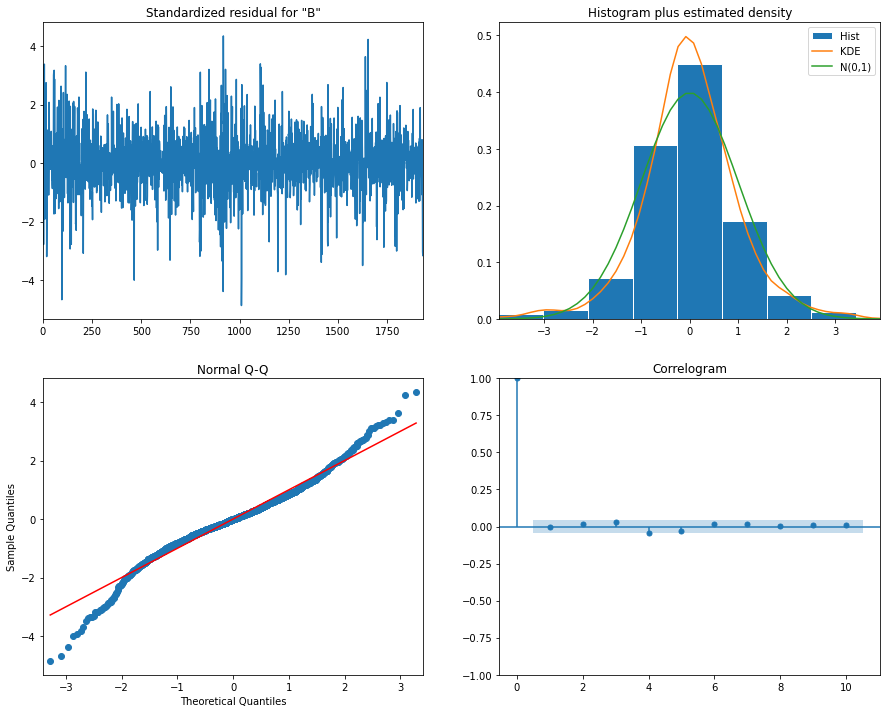

In [56]:
#TEST#################################################################################################
#Fit Reg-ARIMA(1,0,0) to dataset
#TEST#######################################

#GARCH(1,1)
#Fit Reg-ARIMA(1,0,0) to dataset
AR_model = ARIMA(regAR_1_train['BAC_Log_Return'], exog = regAR_1_train['SnP500_Lag_Return'], order=(1,0,0), trend = None,
enforce_stationarity=True, enforce_invertibility=True, concentrate_scale=True)
AR_res = AR_model.fit()
print(AR_res.summary())
AR_res.plot_diagnostics(figsize=(15, 12))
plt.show()

In [70]:
#TESTTTTTT
model_1 = arch_model(AR_res.resid,mean ='Constant', vol ='GARCH', p=1, q=1)
res_1 =model_1.fit(disp='off')
print(res_1.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3606.53
Distribution:                  Normal   AIC:                           7221.06
Method:            Maximum Likelihood   BIC:                           7243.33
                                        No. Observations:                 1935
Date:                Fri, Aug 12 2022   Df Residuals:                     1934
Time:                        10:01:58   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0278  3.346e-02      0.830      0.407 

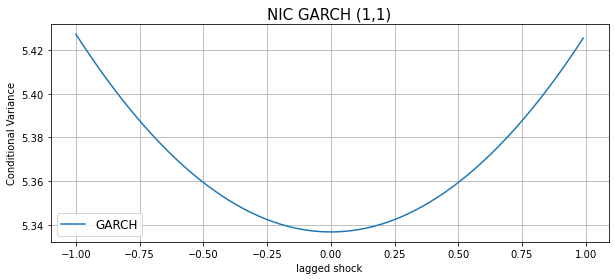

In [71]:
####################################################################
omega_1 = res_1.params['omega']
alpha_1 = res_1.params['alpha[1]']
beta_1 = res_1.params['beta[1]']

#forecasting variance
forecast_1 = res_1.forecast()
var = forecast_1.residual_variance.tail(1).values
#forecasting lag_residuals
lag_resid_array = np.arange(-1,1,0.01)
lag_resid = pd.DataFrame(lag_resid_array)
#forecasting conditional variance
cond_var_1 = omega_1 + beta_1*var + alpha_1*lag_resid**2
#NIC GARCH Plot
plt.figure(figsize=(10,4))
plt.plot(lag_resid.values,cond_var_1.values, label='GARCH')
plt.title('NIC GARCH (1,1)', size=15)
plt.legend(loc='best', fontsize='large')
plt.ylabel('Conditional Variance')
plt.xlabel('lagged shock')
plt.grid(True)
plt.show()

In [72]:
#TEST@#############################
rolling_predictions_1= []
test_size = len(data_evaluation)
for i in range(test_size):
    train = AR_res.resid[:-(test_size-i)]
    model = arch_model(train,mean ='Constant', vol ='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = True)
    rolling_predictions_1.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions_1 = pd.Series(rolling_predictions_1, index=data_evaluation['BAC_Log_Return'].index[-test_size:])

In [66]:
#TESTTTT
rolling_predictions_2 = []
test_size = len(data_evaluation)
for i in range(test_size):
    train = AR_res.resid[:-(test_size-i)]
    model = model = arch_model(train, mean ='Zero',vol='GARCH', p=1,o=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = True)
    rolling_predictions_2.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions_2 = pd.Series(rolling_predictions_2, index=data_evaluation['BAC_Log_Return'].index[-test_size:])

In [67]:
#TESTTTTTTTTTTTTT
rolling_predictions_3 = []
test_size = len(data_evaluation)
for i in range(test_size):
    train = AR_res.resid[:-(test_size-i)]
    model = arch_model(train, mean ='Zero',vol='EGARCH', p=1,o=1, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = True)
    rolling_predictions_3.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions_3 = pd.Series(rolling_predictions_3, index=data_evaluation['BAC_Log_Return'].index[-test_size:])

In [79]:
model = arch_model(AR_res.resid, mean = 'zero', vol = 'GARCH', p = 1, q = 1)
x_1 = model.fit(disp = 'off')
x_1

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3606.86
Distribution:                  Normal   AIC:                           7219.72
Method:            Maximum Likelihood   BIC:                           7236.43
                                        No. Observations:                 1935
Date:                Fri, Aug 12 2022   Df Residuals:                     1935
Time:                        10:09:18   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2455      0.131      1.870  6.147e-02 [-1.18

In [80]:
ewma = model.fix([0, 0.06, 0.94])
print(ewma.summary())

                           Zero Mean - GARCH Model Results                           
Dep. Variable:                          None   R-squared:                          --
Mean Model:                        Zero Mean   Adj. R-squared:                     --
Vol Model:                             GARCH   Log-Likelihood:               -3646.65
Distribution:                         Normal   AIC:                           7299.31
Method:            User-specified Parameters   BIC:                           7316.01
                                               No. Observations:                 1935
Date:                       Fri, Aug 12 2022                                         
Time:                               10:09:31                                         
   Volatility Model  
                 coef
---------------------
omega          0.0000
alpha[1]       0.0600
beta[1]        0.9400

Results generated with user-specified parameters.
Std. errors not available when the model is

In [ ]:
#get the conditional volitility for GARCH(1,1) model

con_vol1 = x_1.conditional_volatility

#get ewma conditional vol
ewma_con_vol1 = ewma.conditional_volatility

#plot the ewma curve 
con_vol1.plot(figsize = (12,6), color = 'orange', label = 'GARCH(1,1)')
ewma_con_vol1.plot(figsize = (12,6), color = 'red', label = 'EWMA')
plt.title('EWMA and GARCH Conditional Volitility', size = 15)
plt.legend(loc = 'best')
plt.show()

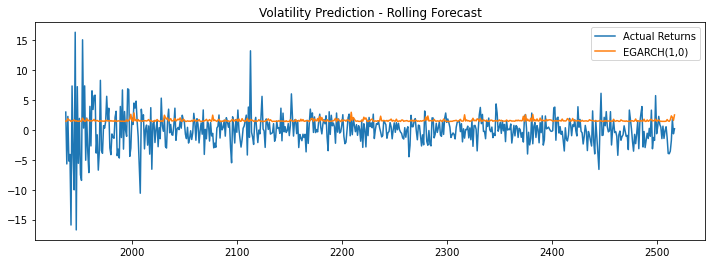

In [81]:
#TESTTTTTTTTTTTTTTTTTTTTTTTTTTT#####################################################################
plt.figure(figsize=(12,4))
plt.plot(data_evaluation['BAC_Log_Return'][-test_size:], label = 'Actual Returns')
#plt.plot(rolling_predictions_1, label = 'GARCH(1,1)')
#plt.plot(rolling_predictions_2, label = 'GJR - GARCH(1,1)')
plt.plot(rolling_predictions_3, label = 'EGARCH(1,0)')
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
regAR_1_dta = data[['Date','BAC_Log_Return','SnP500_Log_Return']].copy().dropna()

regAR_1_dta['BAC_Lag_Return'] = regAR_1_dta['BAC_Log_Return'].shift()
regAR_1_dta.dropna()
regAR_1_dta['SnP500_Lag_Return'] = regAR_1_dta['SnP500_Log_Return'].shift().dropna()

In [17]:
#ARIMA model 

#Creating market lag in data
regAR_1_train = data_in_sample[['Date','BAC_Log_Return','SnP500_Log_Return']].copy()
regAR_1_train.dropna()
regAR_1_test = data_evaluation[['Date','BAC_Log_Return','SnP500_Log_Return']].copy()
regAR_1_test.dropna()


regAR_1_train['BAC_Lag_Return'] = regAR_1_train['regAR_1_train'].shift()
regAR_1_test['BAC_Lag_Return'] = regAR_1_test['BAC_Log_Return'].shift()

regAR_1_train['SnP500_Lag_Return'] = regAR_1_train['SnP500_Log_Return'].shift()
regAR_1_test['SnP500_Lag_Return'] = regAR_1_test['SnP500_Log_Return'].shift()

regAR_1_train = regAR_1_train.dropna()
regAR_1_test = regAR_1_test.dropna()

In [23]:
#plot the ARIMA model 
training_data = regAR_1_train['BAC_Log_Return'].values
test_data = regAR_1_test['BAC_Log_Return'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order = (1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

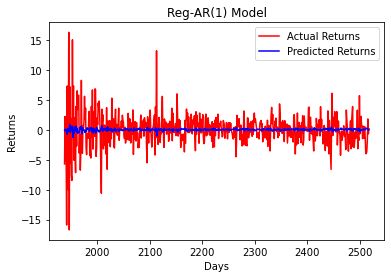

In [39]:
test_set_range = regAR_1_test.index

plt.plot(test_set_range, test_data, color = 'red', label = 'Actual Returns')
plt.plot(test_set_range, model_predictions, color = 'blue', label = 'Predicted Returns')


plt.title('Reg-AR(1) Model')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [35]:
#Calculate the RMSFE and RMAFE values for Naive Model 

#RMSE
MSE = mean_squared_error(test_data, model_predictions)
RMSFE = math.sqrt(MSE)

#RMAE
MAE = mean_absolute_error(test_data, model_predictions)
RMAFE = math.sqrt(MAE)

print("Root Mean Square Forecast Error: " + str(RMSFE))
print("Root Mean Absolute Forecast Error: " + str(RMAFE))

Root Mean Square Forecast Error: 2.778593380587086
Root Mean Absolute Forecast Error: 1.3678740875039814


In [ ]:
#arima_11=ARIMA(endog=regAR_1_train.log_returnsNVDA,exog=regAR_1_train['lagged_r_SP500'], order=(1,0,1))
#results = arima_11.fit()
#print(results.summary())
